In [ ]:
# @title # Connect to Drive
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# @title #  Necessary libraries

!pip install torch_geometric



In [ ]:
# @title #  Necessary libraries

import pandas as pd
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool,SAGEConv, GATConv,GINConv
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt



In [ ]:
# @title # Load the Dataset

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EEG.machinelearing_data_BRMH.csv")


print(data.info())
print("\n")
print(data.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB
None


   no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         21.496226         21.846832  ...   
4  Alcohol use disorder         37.775667  

In [ ]:
# @title # Cleaning Steps
missing_values = data.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])

total_missing = data.isna().sum().sum()
print("\nTotal number of missing values in the dataset:", total_missing)



Missing values per column:
 education        15
IQ               13
Unnamed: 122    945
dtype: int64

Total number of missing values in the dataset: 973


In [ ]:
# @title # dropping Unnecessary columns
data = data.drop(columns=['Unnamed: 122','education','IQ','no.','eeg.date','specific.disorder','sex','age'])

In [ ]:
# @title # Cleaning Steps
print(data.isna().sum())



main.disorder            0
AB.A.delta.a.FP1         0
AB.A.delta.b.FP2         0
AB.A.delta.c.F7          0
AB.A.delta.d.F3          0
                        ..
COH.F.gamma.p.P4.r.O1    0
COH.F.gamma.p.P4.s.O2    0
COH.F.gamma.q.T6.r.O1    0
COH.F.gamma.q.T6.s.O2    0
COH.F.gamma.r.O1.s.O2    0
Length: 1141, dtype: int64


In [ ]:
data.shape

(945, 1141)

<ipython-input-9-de7403e2dbde>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["main.disorder"], palette='Set2')


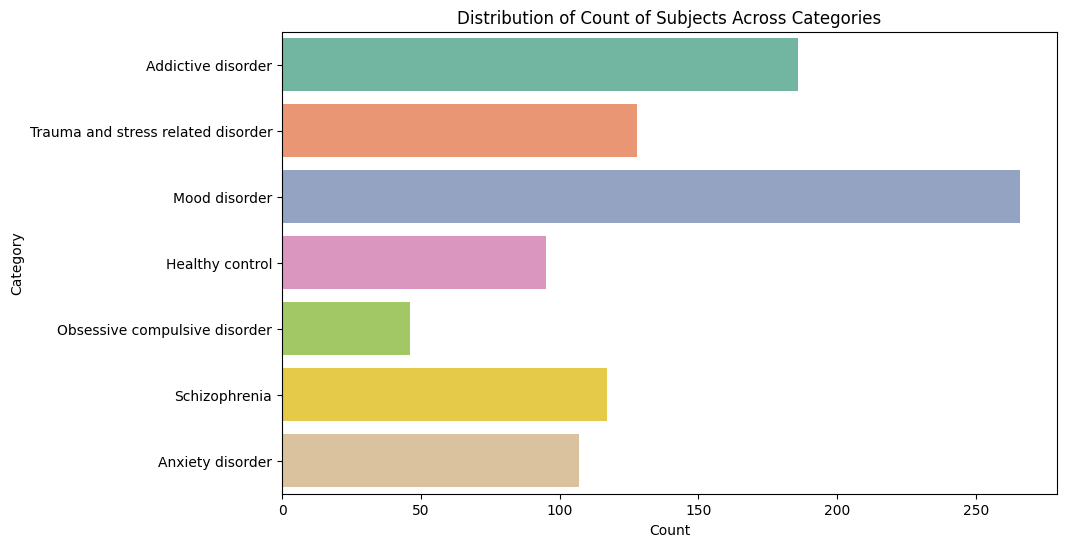

In [ ]:

# @title # Visualizing
plt.figure(figsize=(10, 6))
sns.countplot(y=data["main.disorder"], palette='Set2')
plt.title('Distribution of Count of Subjects Across Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()



In [ ]:
patient_eeg_data = data
patient_eeg_data.rename(columns={"main.disorder": "main_disorder"}, inplace=True)
patient_eeg_data.head()

patient_eeg_data['main_disorder'].value_counts()



,count
main_disorder,
Mood disorder,266
Addictive disorder,186
Trauma and stress related disorder,128
Schizophrenia,117
Anxiety disorder,107
Healthy control,95
Obsessive compulsive disorder,46


In [ ]:
# @title #LabelEncoding Categorical values

labelencoder=LabelEncoder()
patient_eeg_data['main_disorder']=labelencoder.fit_transform(patient_eeg_data['main_disorder'])
patient_eeg_data.head()



,main_disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,0,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,0,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,0,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,0,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [ ]:
# @title #Formatting Column names
def reformat_name(name):
    splitted = name.split(sep='.')

    if len(splitted) < 5:
        return name

    if splitted[0] == 'COH':
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}'

    return result

patient_eeg_data.columns = [
    reformat_name(col) if col.startswith('AB') or col.startswith('COH') else col
    for col in patient_eeg_data.columns
]

patient_eeg_data.head()



,main_disorder,AB.delta.FP1,AB.delta.FP2,AB.delta.F7,AB.delta.F3,AB.delta.Fz,AB.delta.F4,AB.delta.F8,AB.delta.T3,AB.delta.C3,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,0,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,0,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,0,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,0,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [ ]:
patient_eeg_data.columns = patient_eeg_data.columns.str.replace('highbeta', 'high', regex=False)

print(patient_eeg_data.columns)



Index(['main_disorder', 'AB.delta.FP1', 'AB.delta.FP2', 'AB.delta.F7',
       'AB.delta.F3', 'AB.delta.Fz', 'AB.delta.F4', 'AB.delta.F8',
       'AB.delta.T3', 'AB.delta.C3',
       ...
       'COH.gamma.Pz.P4', 'COH.gamma.Pz.T6', 'COH.gamma.Pz.O1',
       'COH.gamma.Pz.O2', 'COH.gamma.P4.T6', 'COH.gamma.P4.O1',
       'COH.gamma.P4.O2', 'COH.gamma.T6.O1', 'COH.gamma.T6.O2',
       'COH.gamma.O1.O2'],
      dtype='object', length=1141)


In [ ]:
# @title # PSD and FC
Nodes = [col for col in patient_eeg_data.columns if 'AB' in col]
Edges = [col for col in patient_eeg_data.columns if 'COH' in col]

print("PSD Columns:", Nodes)
print("COH Columns:", Edges)
print("Total PSDs:", len(Nodes))
print("Total COHs:", len(Edges))



PSD Columns: ['AB.delta.FP1', 'AB.delta.FP2', 'AB.delta.F7', 'AB.delta.F3', 'AB.delta.Fz', 'AB.delta.F4', 'AB.delta.F8', 'AB.delta.T3', 'AB.delta.C3', 'AB.delta.Cz', 'AB.delta.C4', 'AB.delta.T4', 'AB.delta.T5', 'AB.delta.P3', 'AB.delta.Pz', 'AB.delta.P4', 'AB.delta.T6', 'AB.delta.O1', 'AB.delta.O2', 'AB.theta.FP1', 'AB.theta.FP2', 'AB.theta.F7', 'AB.theta.F3', 'AB.theta.Fz', 'AB.theta.F4', 'AB.theta.F8', 'AB.theta.T3', 'AB.theta.C3', 'AB.theta.Cz', 'AB.theta.C4', 'AB.theta.T4', 'AB.theta.T5', 'AB.theta.P3', 'AB.theta.Pz', 'AB.theta.P4', 'AB.theta.T6', 'AB.theta.O1', 'AB.theta.O2', 'AB.alpha.FP1', 'AB.alpha.FP2', 'AB.alpha.F7', 'AB.alpha.F3', 'AB.alpha.Fz', 'AB.alpha.F4', 'AB.alpha.F8', 'AB.alpha.T3', 'AB.alpha.C3', 'AB.alpha.Cz', 'AB.alpha.C4', 'AB.alpha.T4', 'AB.alpha.T5', 'AB.alpha.P3', 'AB.alpha.Pz', 'AB.alpha.P4', 'AB.alpha.T6', 'AB.alpha.O1', 'AB.alpha.O2', 'AB.beta.FP1', 'AB.beta.FP2', 'AB.beta.F7', 'AB.beta.F3', 'AB.beta.Fz', 'AB.beta.F4', 'AB.beta.F8', 'AB.beta.T3', 'AB.beta.C3

In [ ]:
# @title #Scaled PSD and FC
scaler = StandardScaler()
patient_eeg_data[Nodes] = scaler.fit_transform(patient_eeg_data[Nodes])
patient_eeg_data[Edges] = scaler.fit_transform(patient_eeg_data[Edges])
patient_eeg_data.head()



,main_disorder,AB.delta.FP1,AB.delta.FP2,AB.delta.F7,AB.delta.F3,AB.delta.Fz,AB.delta.F4,AB.delta.F8,AB.delta.T3,AB.delta.C3,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,0,1.402585,0.044158,0.376937,0.873128,0.633045,0.675020,-0.051667,2.464746,0.727570,...,-1.255291,-1.961407,-1.829304,-0.834677,-2.238760,-1.572719,-1.056563,-1.437867,-1.750438,-1.451943
1,0,-0.599307,-0.832339,-0.580802,-0.399957,-0.646505,-0.760662,-0.928586,-0.247131,-0.190612,...,-1.910903,-1.921925,-1.647775,-1.803331,-0.718020,-0.787133,-0.380797,-1.222354,-0.460279,-0.693881
2,0,0.865449,0.520861,-0.059950,0.518725,0.681957,-0.643312,-0.055924,0.134177,0.640704,...,1.487760,0.798964,-0.973313,0.508876,0.069677,-0.474096,0.180730,-0.583297,-0.074676,-1.305296
3,0,0.116467,0.054748,-0.038530,-0.558477,-0.651703,-0.690924,-0.262061,-0.507484,-0.654060,...,-1.003143,0.449174,-1.118166,-0.754969,0.837050,-1.176012,-0.971431,-0.191613,0.756112,-0.812381
4,0,1.560186,1.016844,0.411670,0.316233,0.247229,0.212601,-0.115804,-0.320787,-0.140892,...,-0.910029,0.210786,-0.299953,-0.116595,0.612801,0.725577,0.532087,1.044399,1.178291,0.687884


In [ ]:
# @title # Node Feature Matrix over 6 Frequency Bands

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma','high']
node_features = []

for band in bands:
    band_cols = [col for col in Nodes if band in col]
    print(f"Columns for {band}: {len(band_cols)}")

    node_band_data = patient_eeg_data[band_cols].values
    node_features.append(node_band_data)

for i, features in enumerate(node_features):
    print(f"Band {bands[i]} node feature shape: {features.shape}")

node_features = np.stack(node_features, axis=2)
print("Final node feature shape:", node_features.shape)




Columns for delta: 19
Columns for theta: 19
Columns for alpha: 19
Columns for beta: 19
Columns for gamma: 19
Columns for high: 19
Band delta node feature shape: (945, 19)
Band theta node feature shape: (945, 19)
Band alpha node feature shape: (945, 19)
Band beta node feature shape: (945, 19)
Band gamma node feature shape: (945, 19)
Band high node feature shape: (945, 19)
Final node feature shape: (945, 19, 6)


In [ ]:
# @title #Edge Indices

electrode_names=['FP1','FP2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2']
edge_indices = []
for col in Edges[:171]:
    electrodes = col.split('.')[2:4]
    band = col.split('.')[1]

    source_idx = Nodes.index(f'AB.{band}.{electrodes[0]}')
    target_idx = Nodes.index(f'AB.{band}.{electrodes[1]}')

    if source_idx != -1 and target_idx != -1:
        edge_indices.append((source_idx, target_idx))

edge_indices_tensor = torch.tensor(edge_indices, dtype=torch.long).t()


print("Edge indices shape:", edge_indices_tensor.shape)
print("Edge indices:\n", edge_indices_tensor)




Edge indices shape: torch.Size([2, 171])
Edge indices:
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14,
         14, 14, 14, 15, 15, 15, 16, 16, 17],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  3,
       

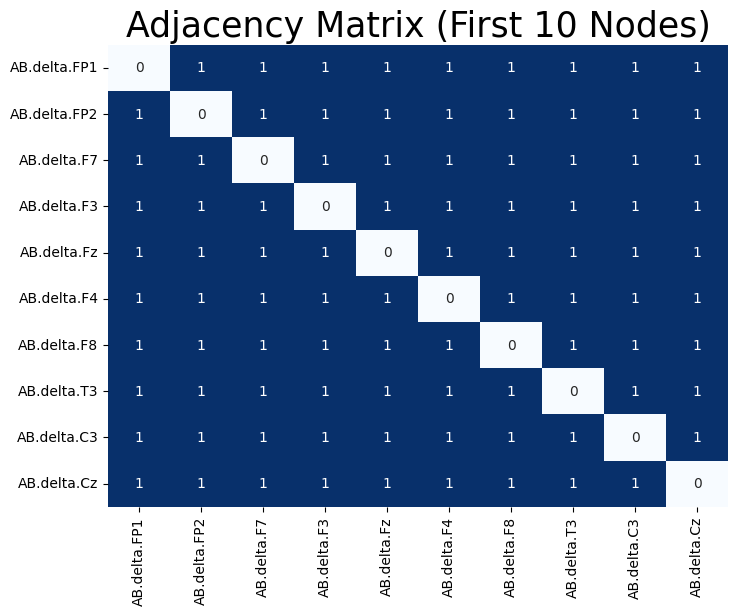

In [ ]:
#@title Adjacency Matrix
num_nodes = len(Nodes)

adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

for source_idx, target_idx in edge_indices:
    adj_matrix[source_idx, target_idx] = 1
    adj_matrix[target_idx, source_idx] = 1

selected_nodes = Nodes[:10]
adj_matrix_small = adj_matrix[:10, :10]

adj_df_small = pd.DataFrame(
    adj_matrix_small,
    index=selected_nodes,
    columns=selected_nodes
)

plt.figure(figsize=(8, 6))
sns.heatmap(adj_df_small, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Adjacency Matrix (First 10 Nodes)",fontsize='25')
plt.show()


In [ ]:

# @title #Edge Feature Matrix

# edge_attributes = []
# for band in bands:
#     band_cols = [col for col in Edges if band in col]
#     edge_band_data = patient_eeg_data[band_cols].values
#     edge_attributes.append(edge_band_data)

# print("Edge attributes shape:", len(edge_attributes))

# for i, attributes in enumerate(edge_attributes):
#     print(f"Band {bands[i]} edge attribute shape: {attributes.shape}")
# edge_attributes = np.stack(edge_attributes, axis=2)

# print("Edge attributes shape:", edge_attributes.shape)



In [ ]:
#@title #Creating 945 Graphs for each subject
graphs = []
for i in range(patient_eeg_data.shape[0]):
    node_feature_matrix = torch.tensor(node_features[i], dtype=torch.float)
    # edge_attr_matrix = torch.tensor(edge_attributes[i], dtype=torch.float)
    label = torch.tensor(patient_eeg_data["main_disorder"].values[i], dtype=torch.long)
    graph = Data(
        x=node_feature_matrix,
        edge_index=edge_indices_tensor,
        # edge_attr=edge_attr_matrix,
        y=label
    )
    graphs.append(graph)



print(len(graphs))



945


In [ ]:
#@title #Fixing the Class Imbalance Problem and also this is the train_loader



X = np.array([graph.x.flatten().numpy() for graph in graphs])
y = np.array([graph.y.item() for graph in graphs])


class_graphs = {label: [] for label in np.unique(y)}
for graph, label in zip(graphs, y):
    class_graphs[label].append(graph)

balanced_graphs = []
for label, samples in class_graphs.items():
    balanced_graphs.extend(
        resample(samples, replace=True, n_samples=500, random_state=42)
    )

np.random.shuffle(balanced_graphs)


In [ ]:
# @title #Count samples for each class in the balanced dataset
balanced_class_counts = Counter([graph.y.item() for graph in balanced_graphs])

print("Class sample counts after balancing:")
for label, count in balanced_class_counts.items():
    print(f"Class {label}: {count} samples")

len(balanced_graphs)

Class sample counts after balancing:
Class 6: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 0: 500 samples
Class 1: 500 samples
Class 4: 500 samples
Class 5: 500 samples


3500

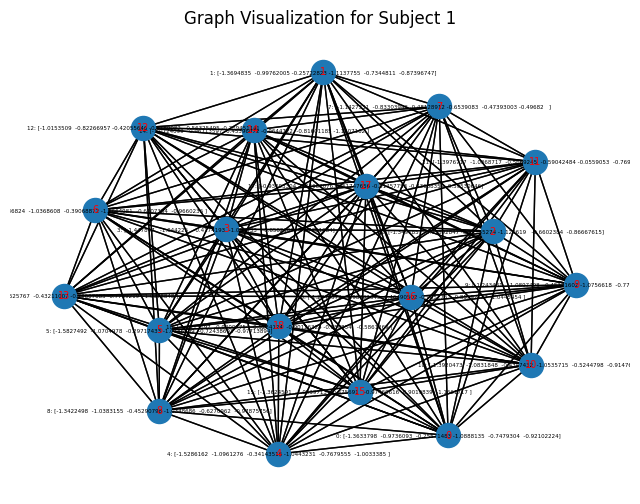

In [ ]:
# @title #Plotting One of the Subjects Graph
from torch_geometric.utils import to_networkx
import networkx as nx
subject_graph = balanced_graphs[0]
G = to_networkx(subject_graph, to_undirected=True)

node_labels = {i: f"{i}: {subject_graph.x[i].numpy()}" for i in range(subject_graph.x.shape[0])}

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.8)

nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=4)



nx.draw_networkx(G, pos, font_color='red',font_size=7)

plt.title("Graph Visualization for Subject 1")
plt.axis('off')
plt.show()



In [ ]:
# @title #One of the Subjects Graph information
first_graph = balanced_graphs[0]


print(f"Graph info : {first_graph}")
print(f" - Number of nodes: {first_graph.num_nodes}")
print(f" - Number of edges: {first_graph.num_edges}")
print(f" - Node feature shape: {first_graph.x.shape}")
print(f" - Edge index shape: {first_graph.edge_index.shape}")
# print(f" - Edge attribute shape: {first_graph.edge_attr.shape}")
print(f" - Graph label: {first_graph.y.item()}\n")





Graph info : Data(x=[19, 6], edge_index=[2, 171], y=3)
 - Number of nodes: 19
 - Number of edges: 171
 - Node feature shape: torch.Size([19, 6])
 - Edge index shape: torch.Size([2, 171])
 - Graph label: 3



In [ ]:
#@title #Test_Loader
train_graphs, test_graphs = train_test_split(balanced_graphs, test_size=0.2, random_state=42)

test_loader = DataLoader(graphs, batch_size=32, shuffle=True)

print(f"Training graphs: {len(balanced_graphs)}, Testing graphs: {len(graphs)}")

Training graphs: 3500, Testing graphs: 945


In [ ]:
# @title #GCN MODEL
class GCNModel(nn.Module):
    def __init__(self):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNConv(6, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.gcn2 = GCNConv(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.gcn3 = GCNConv(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64, len(labelencoder.classes_))
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.leaky_relu(self.bn1(self.gcn1(x, edge_index)), negative_slope=0.01)
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.gcn2(x, edge_index)), negative_slope=0.01)
        x = self.dropout(x)
        x = F.leaky_relu(self.bn3(self.gcn3(x, edge_index)), negative_slope=0.01)
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [ ]:

# @title #GIN Model
class GINModel(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(GINModel, self).__init__()
        self.gin1 = GINConv(nn.Linear(6, 128), train_eps=True)
        self.gin2 = GINConv(nn.Linear(128, 256), train_eps=True)
        self.gin3 = GINConv(nn.Linear(256, 256), train_eps=True)
        self.fc = nn.Linear(256, len(labelencoder.classes_))
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.leaky_relu(self.gin1(x, edge_index), negative_slope=0.01)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.leaky_relu(self.gin2(x, edge_index), negative_slope=0.01)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.leaky_relu(self.gin3(x, edge_index), negative_slope=0.01)
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [ ]:
#@title #Training Function
learning_rate = 0.001
weight_decay = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [ ]:
#@title #Test Function
def test_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            _, preds = output.max(dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    return avg_loss, y_true, y_pred

In [ ]:
Report_Accuracies = {}


In [ ]:
# @title #K fold Train and Evaluation
def kfold_train_and_evaluate(
    model_class, dataset, k_folds=5, epochs=50, batch_size=64, patience=15
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    class_counts = torch.tensor(
        [sum(graph.y.item() == i for graph in dataset) for i in range(len(labelencoder.classes_))],
        dtype=torch.float32
    )
    class_weights = (1.0 / class_counts) * (len(dataset) / len(class_counts))
    class_weights = class_weights.to(device)

    fold_metrics = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    fold = 1
    best_model = None
    best_accuracy = 0

    for train_idx, val_idx in kfold.split(dataset):
        print(f"\n=== Fold {fold}/{k_folds} ===")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

        model = model_class().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        best_val_loss = float('inf')
        no_improve_epochs = 0

        for epoch in range(1, epochs + 1):
            train_loss = train_model(model, train_loader, optimizer, criterion, device)
            train_losses.append(train_loss)

            val_loss, val_true, val_pred = test_model(model, val_loader, criterion, device)
            val_accuracy = np.mean(np.array(val_pred) == np.array(val_true)) * 100
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            _, train_true, train_pred = test_model(model, train_loader, criterion, device)
            train_accuracy = np.mean(np.array(train_pred) == np.array(train_true)) * 100
            train_accuracies.append(train_accuracy)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break

        _, val_true, val_pred = test_model(model, val_loader, criterion, device)
        val_accuracy = np.mean(np.array(val_pred) == np.array(val_true)) * 100
        precision = precision_score(val_true, val_pred, average='weighted') * 100
        recall = recall_score(val_true, val_pred, average='weighted') * 100
        f1 = f1_score(val_true, val_pred, average='weighted') * 100

        print(f"Fold {fold} Results - Accuracy: {val_accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        fold_metrics["accuracy"].append(val_accuracy)
        fold_metrics["precision"].append(precision)
        fold_metrics["recall"].append(recall)
        fold_metrics["f1_score"].append(f1)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

        fold += 1

    mean_accuracy = np.mean(fold_metrics["accuracy"])
    mean_precision = np.mean(fold_metrics["precision"])
    mean_recall = np.mean(fold_metrics["recall"])
    mean_f1 = np.mean(fold_metrics["f1_score"])

    print("\n=== k-Fold Cross-Validation Results ===")
    print(f"Mean Accuracy: {mean_accuracy:.2f}%")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, k_folds + 1), fold_metrics["accuracy"], marker="o", label="Fold Accuracies")
    plt.axhline(y=mean_accuracy, color="r", linestyle="--", label="Mean Accuracy")
    plt.title(f"k-Fold Cross-Validation Results of {'GCN' if model_class == GCNModel else 'GIN'}", fontsize=25)
    plt.xlabel("Fold")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    return best_model


In [ ]:
#@title #Classification Report and confusion Matrix on the unseen Dataset using GIN and GCN:
def Classification_Report_and_confusion_Matrix(best_model, test_loader, criterion, device):
    _, all_true_labels, all_pred_labels = test_model(best_model, test_loader, criterion, device)

    model_name = "GCN" if best_model == "best_GCN_Model" else "GIN"
    print(f"Classification Report of the Best {model_name} Model")
    print(classification_report(all_true_labels, all_pred_labels, target_names=labelencoder.classes_))

    cm = confusion_matrix(all_true_labels, all_pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[str(i) for i in range(len(np.unique(all_true_labels)))],
                yticklabels=[str(i) for i in range(len(np.unique(all_true_labels)))],
                cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix", fontsize='25')
    plt.show()



=== Fold 1/10 ===
Epoch 5: Train Loss: 1.3347, Train Accuracy: 62.44%, Val Loss: 1.2567, Val Accuracy: 58.29%
Epoch 10: Train Loss: 0.9222, Train Accuracy: 70.13%, Val Loss: 0.9887, Val Accuracy: 64.00%
Epoch 15: Train Loss: 0.7248, Train Accuracy: 81.37%, Val Loss: 0.7396, Val Accuracy: 73.14%
Epoch 20: Train Loss: 0.5507, Train Accuracy: 87.56%, Val Loss: 0.7268, Val Accuracy: 79.71%
Epoch 25: Train Loss: 0.3800, Train Accuracy: 89.87%, Val Loss: 0.5483, Val Accuracy: 86.00%
Epoch 30: Train Loss: 0.2785, Train Accuracy: 94.44%, Val Loss: 0.5011, Val Accuracy: 89.43%
Epoch 35: Train Loss: 0.3314, Train Accuracy: 94.86%, Val Loss: 0.4992, Val Accuracy: 90.29%
Epoch 40: Train Loss: 0.1530, Train Accuracy: 97.43%, Val Loss: 0.3421, Val Accuracy: 94.29%
Epoch 45: Train Loss: 0.2608, Train Accuracy: 95.84%, Val Loss: 0.5056, Val Accuracy: 89.71%
Epoch 50: Train Loss: 0.1002, Train Accuracy: 99.21%, Val Loss: 0.3953, Val Accuracy: 95.43%
Fold 1 Results - Accuracy: 95.43%, Precision: 95.446

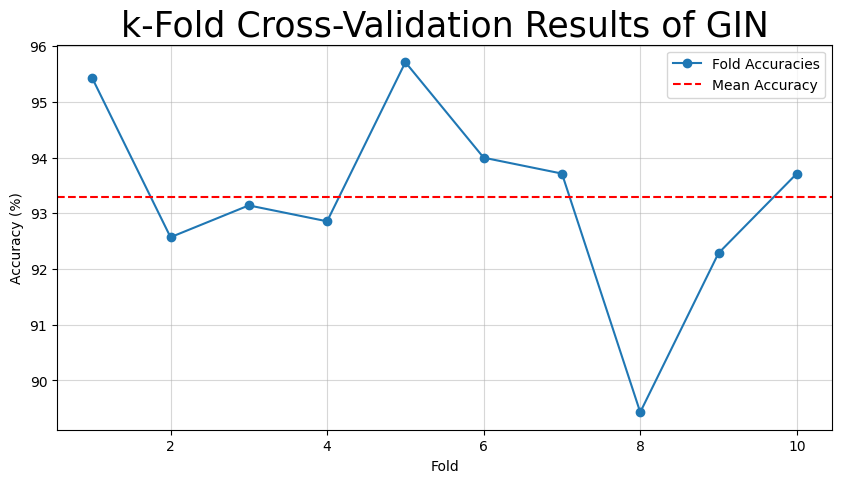

In [ ]:
#@title #GIN Model Training start
best_GIN_model = kfold_train_and_evaluate(
    model_class=GINModel,
    dataset=balanced_graphs,
    k_folds=10,
    epochs=50,
    batch_size=64
)

Classification Report of the Best GIN Model
                                    precision    recall  f1-score   support

                Addictive disorder       0.89      0.90      0.90       186
                  Anxiety disorder       0.89      0.96      0.92       107
                   Healthy control       0.92      1.00      0.96        95
                     Mood disorder       0.92      0.82      0.87       266
     Obsessive compulsive disorder       0.85      1.00      0.92        46
                     Schizophrenia       0.93      0.95      0.94       117
Trauma and stress related disorder       0.95      0.95      0.95       128

                          accuracy                           0.91       945
                         macro avg       0.91      0.94      0.92       945
                      weighted avg       0.91      0.91      0.91       945



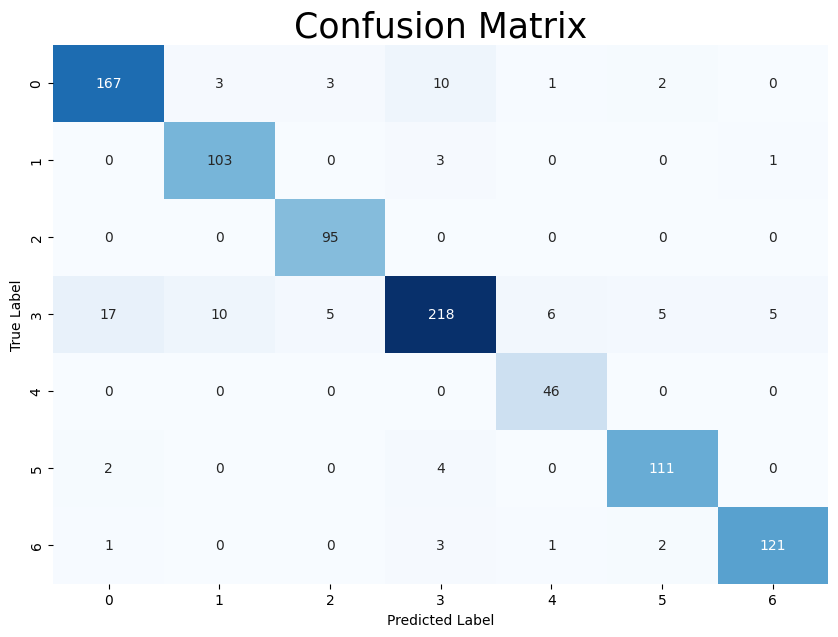

In [ ]:
#@title #Classification Report and confusion Matrix on the unseen Dataset using GIN and GCN: PART-GIN

criterion=nn.CrossEntropyLoss()
Classification_Report_and_confusion_Matrix(best_GIN_model,test_loader,criterion,device)



=== Fold 1/10 ===
Epoch 5: Train Loss: 1.7317, Train Accuracy: 36.63%, Val Loss: 1.7057, Val Accuracy: 36.79%
Epoch 10: Train Loss: 1.6242, Train Accuracy: 46.63%, Val Loss: 1.5941, Val Accuracy: 42.14%
Epoch 15: Train Loss: 1.5529, Train Accuracy: 48.73%, Val Loss: 1.4996, Val Accuracy: 47.50%
Epoch 20: Train Loss: 1.4949, Train Accuracy: 54.05%, Val Loss: 1.4018, Val Accuracy: 51.79%
Epoch 25: Train Loss: 1.4127, Train Accuracy: 56.90%, Val Loss: 1.3680, Val Accuracy: 50.71%
Epoch 30: Train Loss: 1.3655, Train Accuracy: 61.11%, Val Loss: 1.2929, Val Accuracy: 55.36%
Epoch 35: Train Loss: 1.3147, Train Accuracy: 62.62%, Val Loss: 1.2339, Val Accuracy: 58.21%
Epoch 40: Train Loss: 1.2682, Train Accuracy: 64.96%, Val Loss: 1.1974, Val Accuracy: 58.93%
Epoch 45: Train Loss: 1.2422, Train Accuracy: 67.06%, Val Loss: 1.1535, Val Accuracy: 60.00%
Epoch 50: Train Loss: 1.1959, Train Accuracy: 72.22%, Val Loss: 1.1529, Val Accuracy: 64.29%
Fold 1 Results - Accuracy: 64.29%, Precision: 65.383

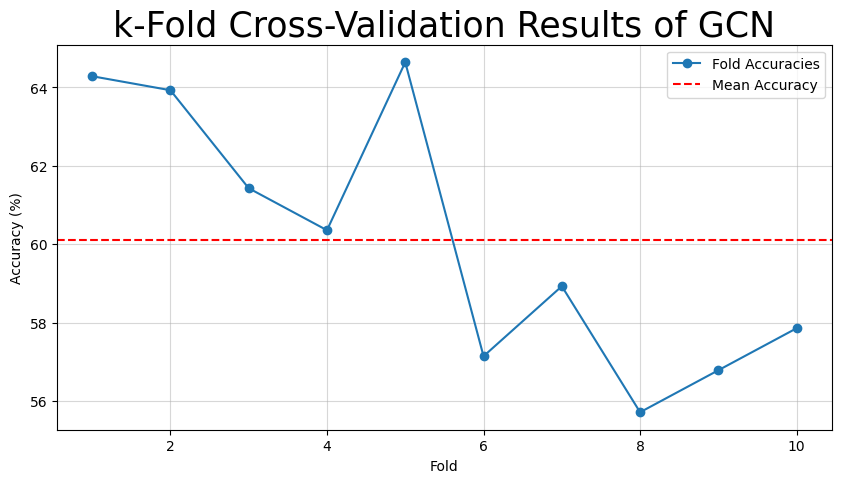

In [ ]:
#@title #GCN Model Training start

best_GCN_Model=kfold_train_and_evaluate(GCNModel, train_graphs, k_folds=10, epochs=50, batch_size=64)


Classification Report of the Best GIN Model
                                    precision    recall  f1-score   support

                Addictive disorder       0.55      0.45      0.49       186
                  Anxiety disorder       0.46      0.70      0.56       107
                   Healthy control       0.43      0.71      0.53        95
                     Mood disorder       0.68      0.33      0.44       266
     Obsessive compulsive disorder       0.43      0.96      0.59        46
                     Schizophrenia       0.52      0.55      0.54       117
Trauma and stress related disorder       0.57      0.55      0.56       128

                          accuracy                           0.52       945
                         macro avg       0.52      0.60      0.53       945
                      weighted avg       0.56      0.52      0.51       945



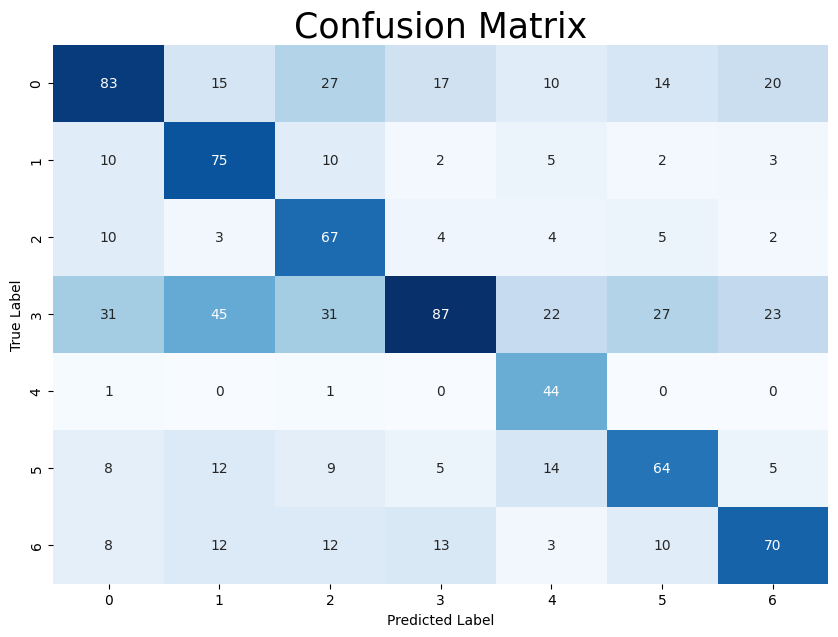

In [ ]:
#@title #Classification Report and confusion Matrix on the unseen Dataset using GIN and GCN: PART-GCN

criterion=nn.CrossEntropyLoss()
Classification_Report_and_confusion_Matrix(best_GCN_Model, test_loader,criterion, device)


<Figure size 1000x600 with 0 Axes>

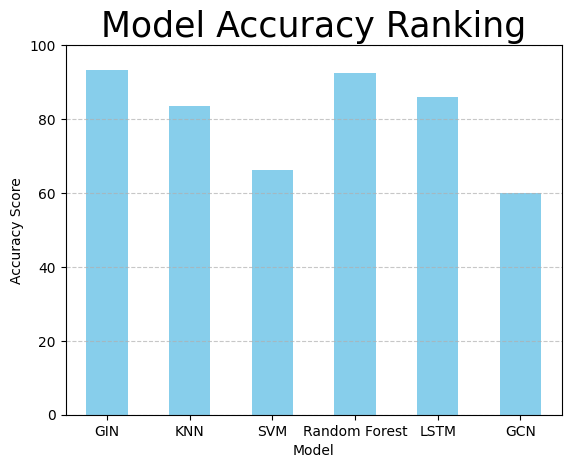

In [ ]:
#@title # Creating a DataFrame with model performance data
result = {
    'Model': ['GIN', 'KNN', 'SVM', 'Random Forest', 'LSTM', 'GCN'],
    'Accuracy': [93.29, 83.51, 66.17, 92.57, 85.83, 60.11],
}

df = pd.DataFrame(result)

plt.figure(figsize=(10, 6))
df.plot(x='Model', y='Accuracy', kind='bar', legend=False, color='skyblue')

plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Ranking', fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.ylim(0, 100)

plt.show()


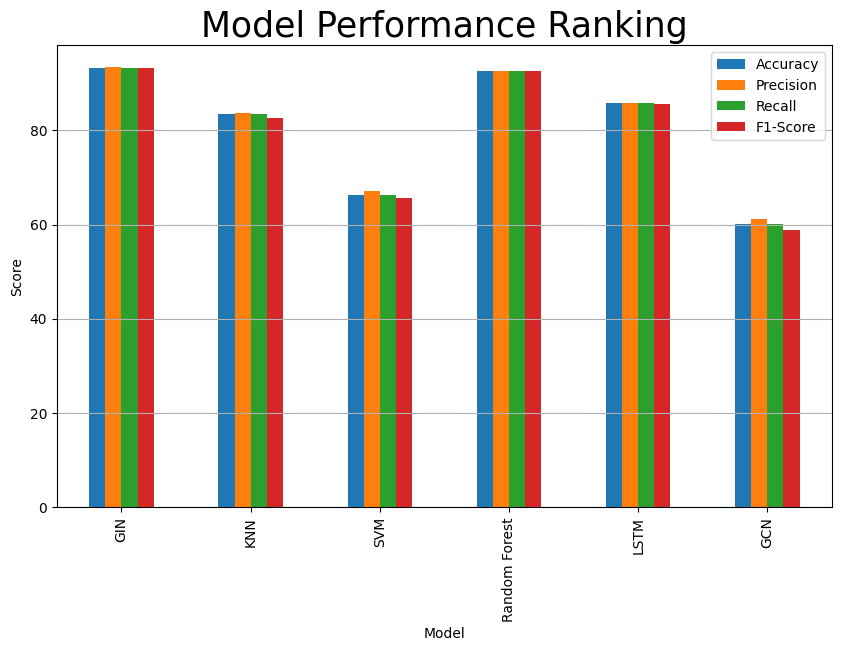

In [ ]:
#@title #Mean Metrics comparision over 6 classfier
result = {
    'Model': ['GIN', 'KNN', 'SVM', 'Random Forest', 'LSTM', 'GCN'],
    'Accuracy':  [93.29, 83.51, 66.17, 92.57, 85.83, 60.11],
    'Precision': [93.42, 83.58, 67.12, 92.66, 85.84, 61.19],
    'Recall':    [93.29, 83.51, 66.17, 92.57, 85.83, 60.11],
    'F1-Score':  [93.21, 82.68, 65.67, 92.50, 85.51, 58.86]
}


df = pd.DataFrame(result)

fig, ax = plt.subplots(figsize=(10, 6))

df.plot(x='Model', kind='bar', ax=ax)

plt.ylabel('Score')
plt.title('Model Performance Ranking',fontsize='25')
plt.grid(axis='y')

plt.show()


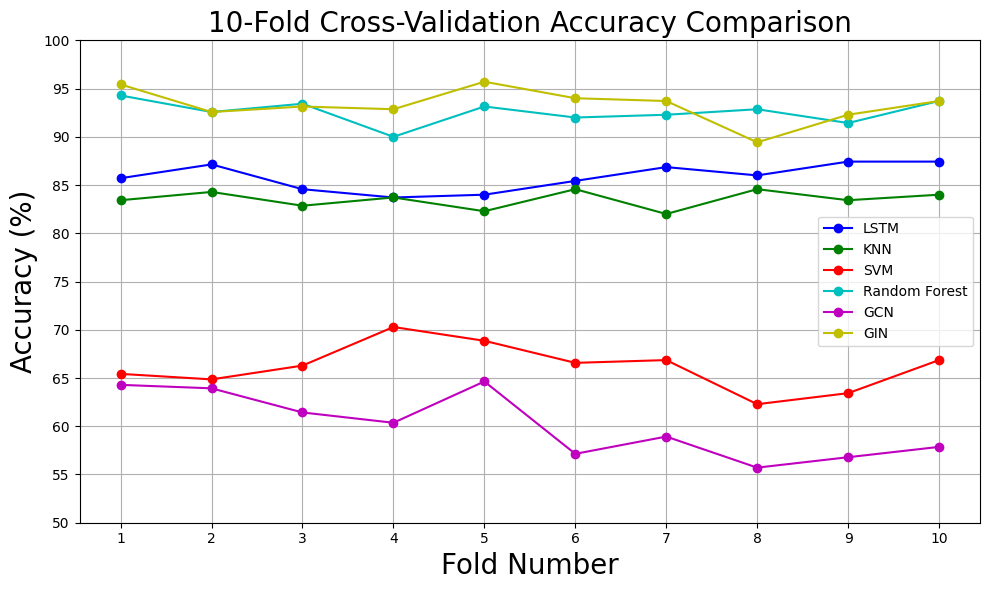

In [ ]:
#@title #10-Fold Cross-Validation Accuracy Comparison
lstm_accuracy = [x * 100 for x in [0.8571, 0.8714, 0.8457, 0.8371, 0.8400, 0.8543, 0.8686, 0.8600, 0.8743, 0.8743]]
knn_accuracy = [x * 100 for x in [0.83428571, 0.84285714, 0.82857143, 0.83714286, 0.82285714, 0.84571429, 0.82000000, 0.84571429, 0.83428571, 0.84000000]]
svm_accuracy = [x * 100 for x in [0.65428571, 0.64857143, 0.66285714, 0.70285714, 0.68857143, 0.66571429, 0.66857143, 0.62285714, 0.63428571, 0.66857143]]
random_forest_accuracy = [x * 100 for x in [0.94285714, 0.92571429, 0.93428571, 0.90000000, 0.93142857, 0.92000000, 0.92285714, 0.92857143, 0.91428571, 0.93714286]]
gcn_accuracy = [x * 100 for x in [0.6429, 0.6393, 0.6143, 0.6036, 0.6464, 0.5714, 0.5893, 0.5571, 0.5679, 0.5786]]
gin_accuracy = [x * 100 for x in [0.9543, 0.9257, 0.9314, 0.9286, 0.9571, 0.9400, 0.9371, 0.8943, 0.9229, 0.9371]]

folds = np.arange(1, 11)

plt.figure(figsize=(10, 6))

plt.plot(folds, lstm_accuracy, label="LSTM", marker='o', linestyle='-', color='b')
plt.plot(folds, knn_accuracy, label="KNN", marker='o', linestyle='-', color='g')
plt.plot(folds, svm_accuracy, label="SVM", marker='o', linestyle='-', color='r')
plt.plot(folds, random_forest_accuracy, label="Random Forest", marker='o', linestyle='-', color='c')
plt.plot(folds, gcn_accuracy, label="GCN", marker='o', linestyle='-', color='m')
plt.plot(folds, gin_accuracy, label="GIN", marker='o', linestyle='-', color='y')

plt.xlabel('Fold Number',fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=20)
plt.title('10-Fold Cross-Validation Accuracy Comparison',fontsize=20)
plt.xticks(folds)
plt.yticks(np.arange(50, 101, 5))

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


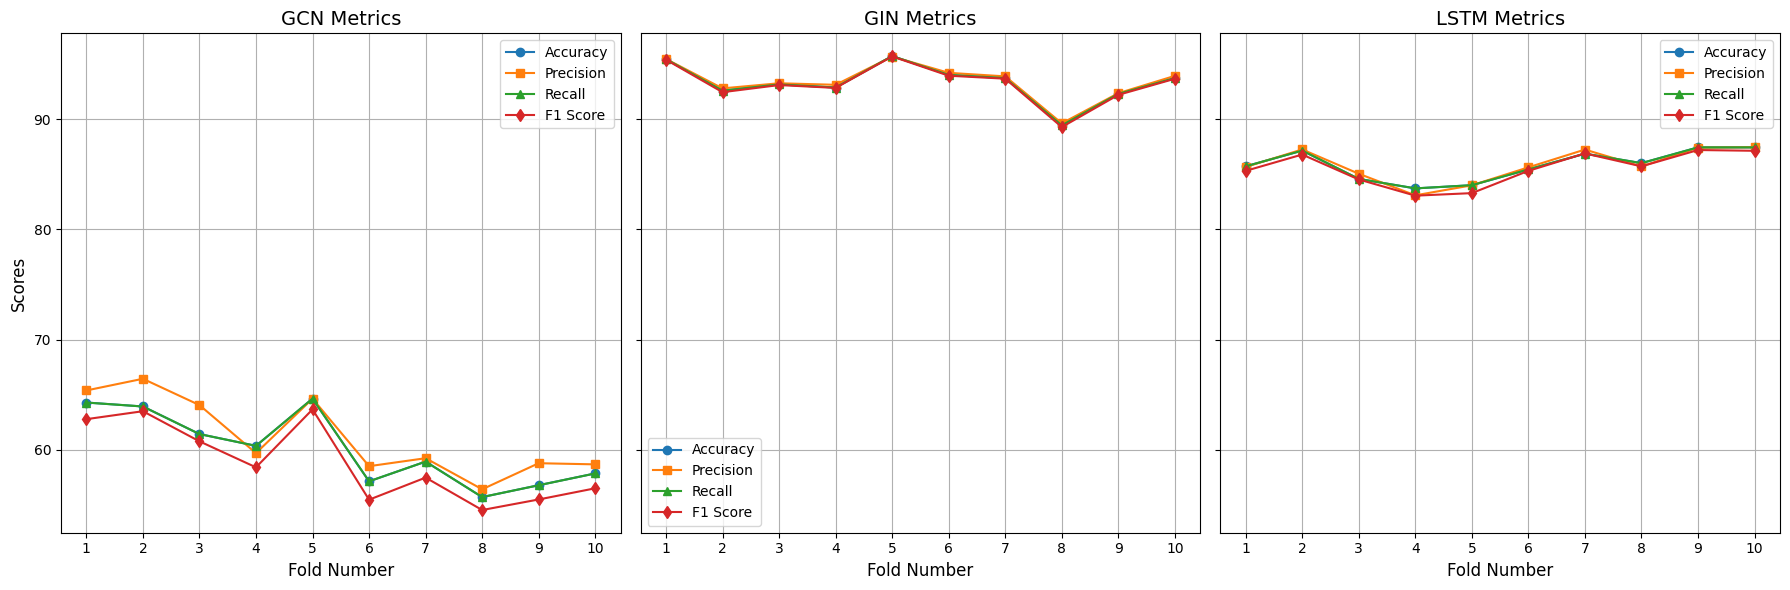

In [ ]:
#@title #Metrics comparison of GIN,GCN,LSTM
results = {
    'GCN': {
        'accuracy': {'scores': [64.29, 63.93, 61.43, 60.36, 64.64, 57.14, 58.93, 55.71, 56.79, 57.86]},
        'precision': {'scores': [65.3831, 66.4424, 64.0571, 59.6978, 64.6368, 58.5150, 59.2386, 56.4199, 58.7844, 58.6801]},
        'recall': {'scores': [64.2857, 63.9286, 61.4286, 60.3571, 64.6429, 57.1429, 58.9286, 55.7143, 56.7857, 57.8571]},
        'f1': {'scores': [62.7794, 63.5005, 60.7701, 58.4111, 63.6665, 55.4754, 57.4805, 54.5391, 55.4963, 56.5104]}
    },
    'GIN': {
        'accuracy': {'scores': [95.43, 92.57, 93.14, 92.86, 95.71, 94.00, 93.71, 89.43, 92.29, 93.71]},
        'precision': {'scores': [95.4463, 92.7808, 93.2443, 93.1047, 95.6674, 94.1902, 93.8694, 89.6107, 92.3463, 93.9177]},
        'recall': {'scores': [95.4286, 92.5714, 93.1429, 92.8571, 95.7143, 94.0000, 93.7143, 89.4286, 92.2857, 93.7143]},
        'f1': {'scores': [95.3818, 92.4352, 93.0824, 92.8235, 95.6771, 93.9290, 93.6593, 89.2713, 92.1939, 93.6523]}
    },
    'LSTM': {
        'accuracy': {'scores': [085.71, 87.14, 84.57, 83.71, 84.00, 085.43, 086.86, 86.00, 087.43, 087.43]},
        'precision': {'scores': [85.65, 87.24, 85.04, 83.08, 83.99, 85.62, 087.23, 085.70, 087.40, 87.45]},
        'recall': {'scores': [85.71, 87.14, 84.57, 83.71, 84.00, 085.43, 86.86, 86.00, 087.43, 87.43]},
        'f1': {'scores': [85.30, 86.78,84.52, 83.05, 83.28, 85.30,86.88, 85.71, 87.19, 87.12]}
    }
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, (clf_name, metrics) in enumerate(results.items()):
    ax = axes[idx]
    ax.plot(range(1, 11), metrics['accuracy']['scores'], marker='o', label='Accuracy')
    ax.plot(range(1, 11), metrics['precision']['scores'], marker='s', label='Precision')
    ax.plot(range(1, 11), metrics['recall']['scores'], marker='^', label='Recall')
    ax.plot(range(1, 11), metrics['f1']['scores'], marker='d', label='F1 Score')

    ax.set_title(f"{clf_name} Metrics", fontsize=14)
    ax.set_xlabel('Fold Number', fontsize=12)
    ax.set_xticks(range(1, 11))
    ax.grid(True)
    ax.legend()
    if idx == 0:
        ax.set_ylabel('Scores', fontsize=12)

plt.tight_layout()
plt.show()
